### 초기 경로 설정 (클래스 이용을 위함)

In [1]:
%cd /project/segmentation/smcho1201/segmentation_project

/project/segmentation/smcho1201/segmentation_project


In [2]:
# files and system
import os
import sys
import time
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from IPython.display import clear_output
# working with images
import cv2
import imageio
import scipy.ndimage
# import skimage.transform

import torchvision.transforms as transforms

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F


import torchsummary
from tqdm import notebook

sys.path.insert(0, '..')

# losses
from utils.metrics import iou_pytorch_eval, IoULoss, IoUBCELoss, DiceBCELoss , dice_pytorch_eval
from utils.metrics import iou_pytorch_test, dice_pytorch_test, precision_pytorch_test, recall_pytorch_test, fbeta_pytorch_test, accuracy_pytorch_test

# dataset
from utils.dataset import myDataSet

## 랜덤성을 배제한 환경 고정

In [3]:
random_seed= 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [4]:
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu
print(DEVICE)

cuda:1


# 1. Image augentation
> 실험할 때는 아예 augmentation도 고정시켜서 저장한 이미지를 사용해야 함.

In [5]:
_size = 224, 224
resize = transforms.Resize(_size, interpolation=0)

# set your transforms 
train_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                           transforms.RandomRotation(180),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(_size, padding = 10), # needed after rotation (with original size)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                       ])

/home/smcho1201/.conda/envs/pytorch/lib/python3.9/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


# 2. 데이터셋 클래스 생성
> 해당 클래스는 이용하려는 이미지와 라벨의 모든 경로(/data/segmentation/...)의 리스트를 인자로 받는다.   

In [6]:
train_images = glob.glob('/data/segmentation/ISIC-2017/trainset/images/*')
train_labels = glob.glob('/data/segmentation/ISIC-2017/trainset/labels/*')
train_images = [img for img in train_images if img.find('jpg')!= -1] # super pixels 이미지 제외

valid_images = glob.glob('/data/segmentation/ISIC-2017/validationset/images/*')
valid_labels = glob.glob('/data/segmentation/ISIC-2017/validationset/labels/*')
valid_images = [img for img in valid_images if img.find('jpg')!= -1] # super pixels 이미지 제외


train_images = sorted(train_images)
train_labels = sorted(train_labels)

valid_images = sorted(valid_images)
valid_labels = sorted(valid_labels)


custom_dataset_train = myDataSet(train_images, train_labels, transforms=test_transforms)
print("My custom training-dataset has {} elements".format(len(custom_dataset_train)))


custom_dataset_val = myDataSet(valid_images, valid_labels, transforms=test_transforms)
print("My custom valing-dataset has {} elements".format(len(custom_dataset_val)))


My custom training-dataset has 2000 elements
My custom valing-dataset has 150 elements


### dataset class check
> RGB 채널 평균 값이라 색 바뀜

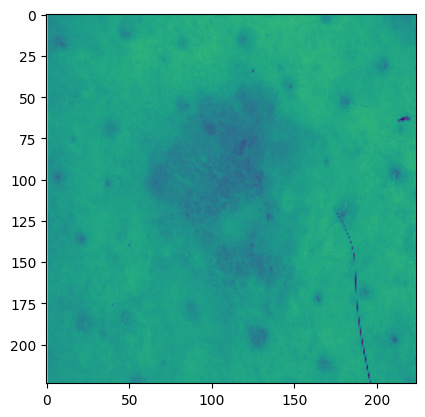

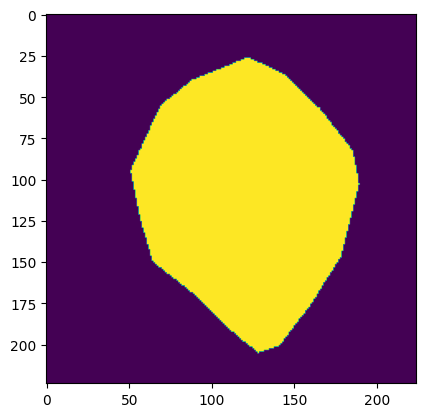

3픽셀의 평균값이라 색깔이 변경됨.


In [7]:
# Show example images.
image_number = 23
img, mask = custom_dataset_train.__getitem__(image_number)

# image
plt.figure()
plt.imshow(img.mean(0)) # 3 channels, take mean

# mask
plt.figure()
plt.imshow(mask[0, :, :]) # 1 channel, take it

plt.show()
print('3픽셀의 평균값이라 색깔이 변경됨.')

# 3. 모델 클래스 생성

In [8]:
# Begin training
from models.nnUNet.nnunet import Nested_UNet as UNet_2p
model = UNet_2p(1,3)
model = model.to(DEVICE) # load model to DEVICE

# 4. 하이퍼 파라미터 세팅 & 데이터 로더 생성

In [9]:
# Define variables for the training
epochs = 100
patience = 20
BATCH_SIZE = 8

dataloader_train = torch.utils.data.DataLoader(custom_dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(custom_dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [10]:
# Define optimiser and criterion for the training. You can try different ones to see which works best for your data and task
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-8)

criterion = DiceBCELoss()
model_name = 'UNet++'
data_name = 'ISIC'

# 5. Training

/home/smcho1201/.conda/envs/pytorch/lib/python3.9/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 Epoch: 1 of 100, Iter.: 250 of 250, Train Loss: 0.883607, IoU: 0.606756, Dice: 0.715644
 Epoch: 1 of 100, Iter.: 250 of 250, Valid Loss: 0.889934, IoU: 0.628628, Dice: 0.734192

시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.


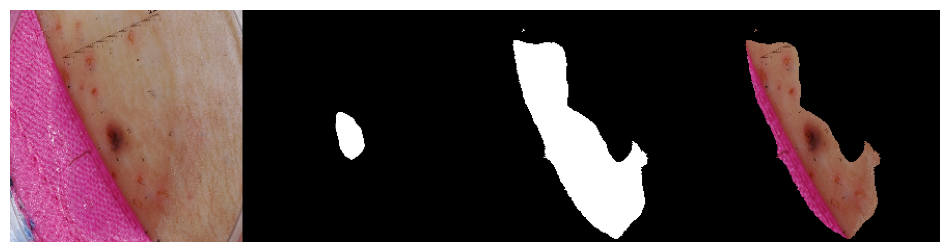

 Epoch: 2 of 100, Iter.: 250 of 250, Train Loss: 0.707353, IoU: 0.693638, Dice: 0.790887
 Epoch: 2 of 100, Iter.: 250 of 250, Valid Loss: 0.816346, IoU: 0.621753, Dice: 0.735504


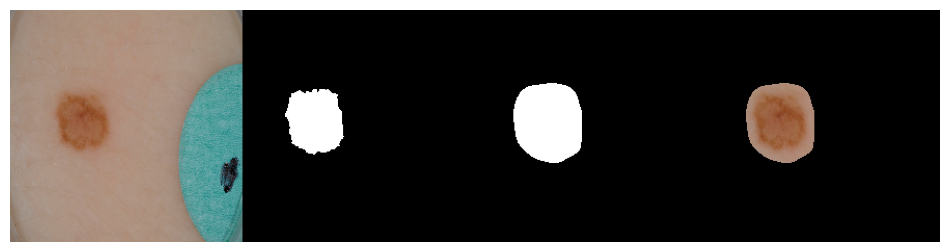

 Epoch: 3 of 100, Iter.: 250 of 250, Train Loss: 0.602252, IoU: 0.726310, Dice: 0.818189
 Epoch: 3 of 100, Iter.: 250 of 250, Valid Loss: 0.713003, IoU: 0.661199, Dice: 0.760878


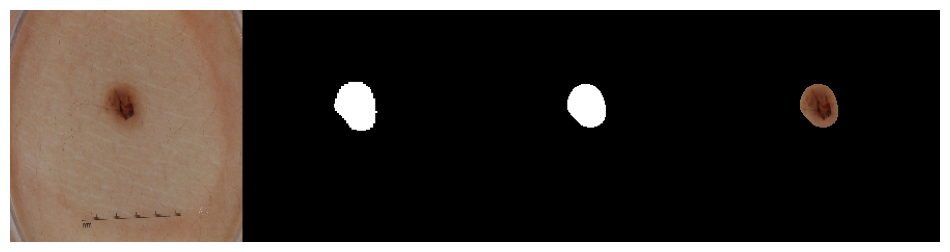

 Epoch: 4 of 100, Iter.: 250 of 250, Train Loss: 0.523306, IoU: 0.745211, Dice: 0.833081
 Epoch: 4 of 100, Iter.: 250 of 250, Valid Loss: 0.626662, IoU: 0.720785, Dice: 0.811297


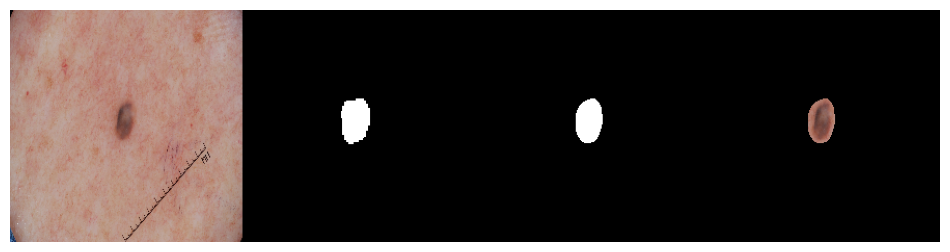

 Epoch: 5 of 100, Iter.: 250 of 250, Train Loss: 0.442632, IoU: 0.765682, Dice: 0.849233
 Epoch: 5 of 100, Iter.: 250 of 250, Valid Loss: 0.559046, IoU: 0.724525, Dice: 0.813750


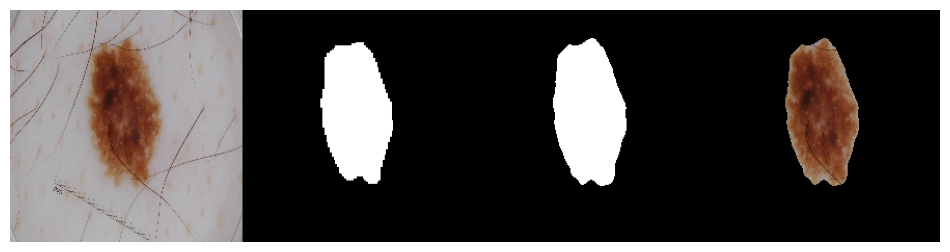

 Epoch: 6 of 100, Iter.: 250 of 250, Train Loss: 0.404710, IoU: 0.768707, Dice: 0.852768
 Epoch: 6 of 100, Iter.: 250 of 250, Valid Loss: 0.540961, IoU: 0.710593, Dice: 0.800750


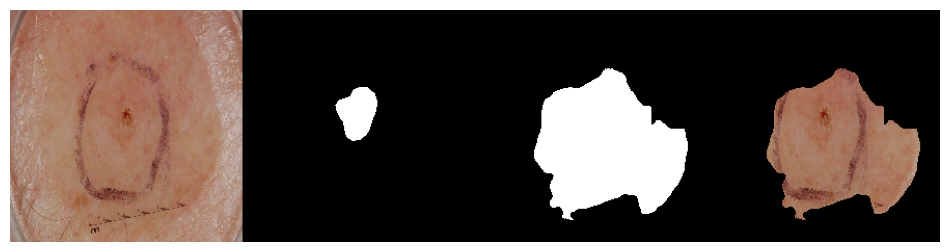

 Epoch: 7 of 100, Iter.: 250 of 250, Train Loss: 0.362951, IoU: 0.781559, Dice: 0.862033
 Epoch: 7 of 100, Iter.: 250 of 250, Valid Loss: 0.546180, IoU: 0.695131, Dice: 0.782380


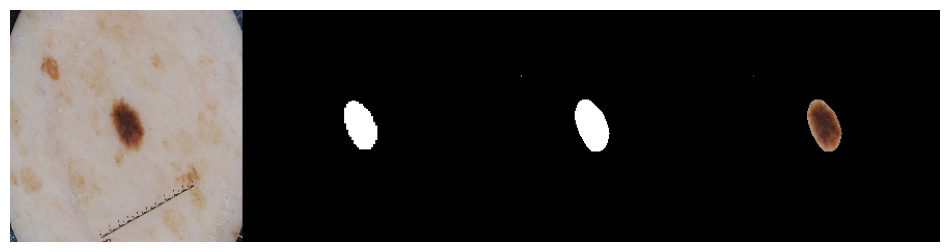

 Epoch: 8 of 100, Iter.: 250 of 250, Train Loss: 0.341269, IoU: 0.784467, Dice: 0.864059
 Epoch: 8 of 100, Iter.: 250 of 250, Valid Loss: 0.484822, IoU: 0.726529, Dice: 0.814298


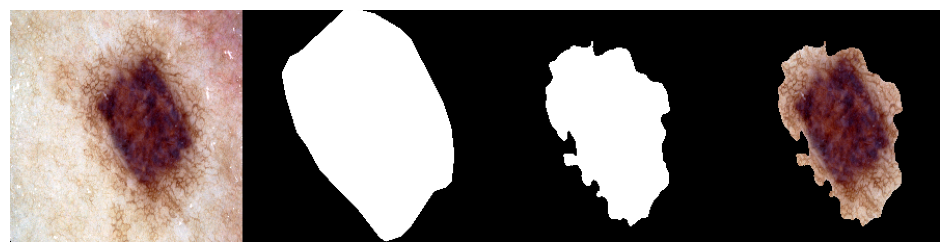

 Epoch: 9 of 100, Iter.: 250 of 250, Train Loss: 0.304782, IoU: 0.793805, Dice: 0.871827
 Epoch: 9 of 100, Iter.: 250 of 250, Valid Loss: 0.474832, IoU: 0.723656, Dice: 0.810529


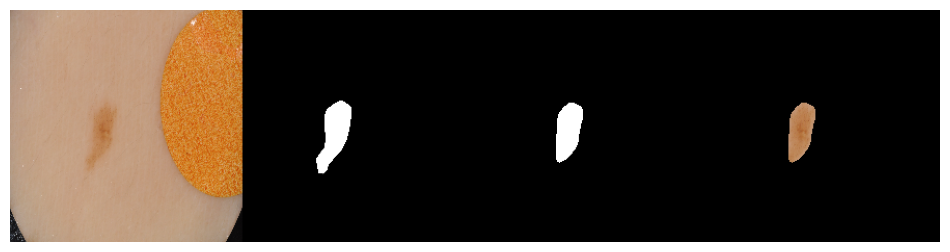

 Epoch: 10 of 100, Iter.: 250 of 250, Train Loss: 0.289405, IoU: 0.800376, Dice: 0.876499
 Epoch: 10 of 100, Iter.: 250 of 250, Valid Loss: 0.440125, IoU: 0.724755, Dice: 0.815166


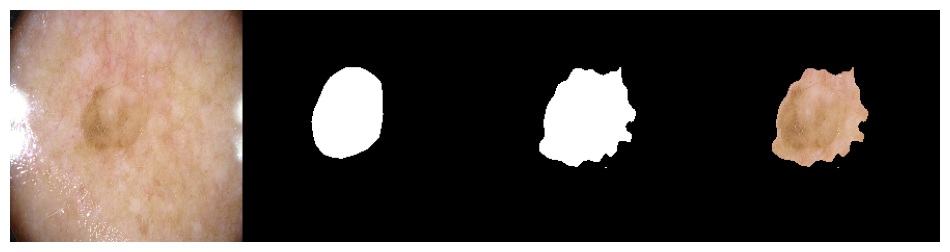

 Epoch: 11 of 100, Iter.: 250 of 250, Train Loss: 0.268556, IoU: 0.806474, Dice: 0.881353
 Epoch: 11 of 100, Iter.: 250 of 250, Valid Loss: 0.442143, IoU: 0.723532, Dice: 0.816636


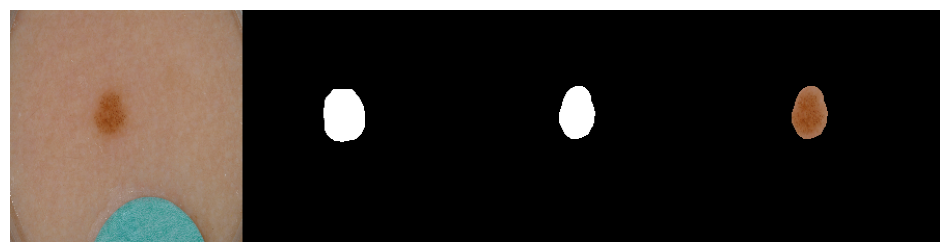

 Epoch: 12 of 100, Iter.: 250 of 250, Train Loss: 0.261054, IoU: 0.809389, Dice: 0.883167
 Epoch: 12 of 100, Iter.: 250 of 250, Valid Loss: 0.459460, IoU: 0.733071, Dice: 0.819064


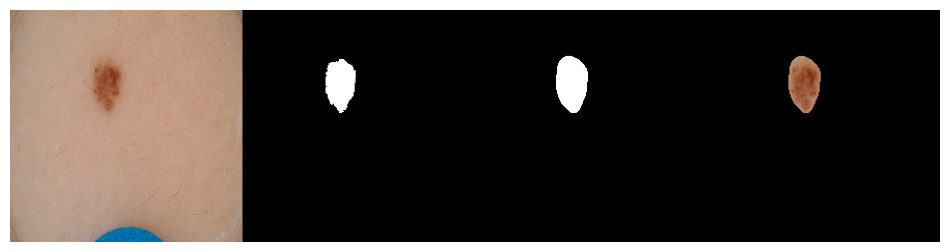

 Epoch: 13 of 100, Iter.: 250 of 250, Train Loss: 0.242298, IoU: 0.810886, Dice: 0.884096
 Epoch: 13 of 100, Iter.: 250 of 250, Valid Loss: 0.445826, IoU: 0.727743, Dice: 0.818974


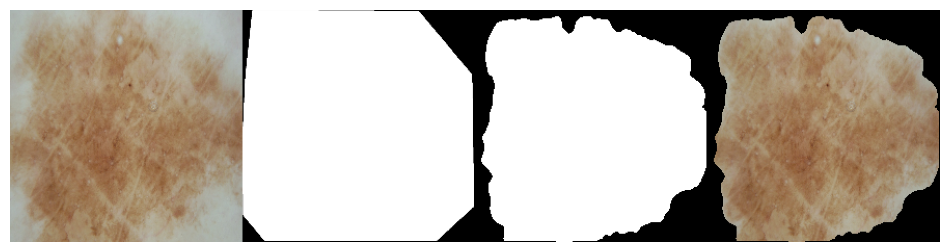

 Epoch: 14 of 100, Iter.: 250 of 250, Train Loss: 0.239657, IoU: 0.816440, Dice: 0.888258
 Epoch: 14 of 100, Iter.: 250 of 250, Valid Loss: 0.442057, IoU: 0.738352, Dice: 0.830541


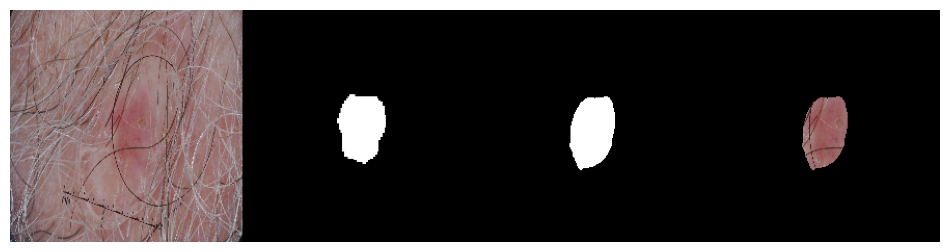

 Epoch: 15 of 100, Iter.: 250 of 250, Train Loss: 0.228947, IoU: 0.818593, Dice: 0.890292
 Epoch: 15 of 100, Iter.: 250 of 250, Valid Loss: 0.488538, IoU: 0.727039, Dice: 0.814806


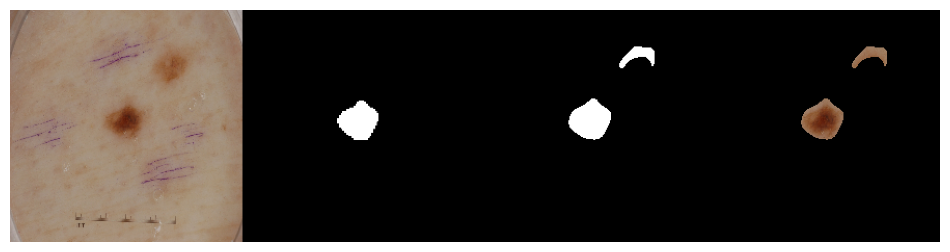

 Epoch: 16 of 100, Iter.: 250 of 250, Train Loss: 0.222129, IoU: 0.822849, Dice: 0.893733
 Epoch: 16 of 100, Iter.: 250 of 250, Valid Loss: 0.435545, IoU: 0.742370, Dice: 0.831682


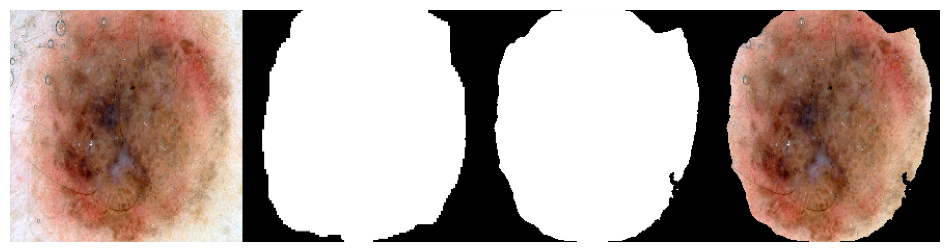

 Epoch: 17 of 100, Iter.: 250 of 250, Train Loss: 0.203552, IoU: 0.833900, Dice: 0.901915
 Epoch: 17 of 100, Iter.: 250 of 250, Valid Loss: 0.435151, IoU: 0.735772, Dice: 0.824815


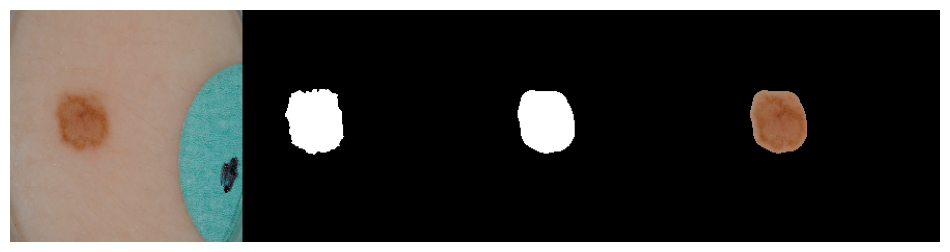

 Epoch: 18 of 100, Iter.: 250 of 250, Train Loss: 0.200730, IoU: 0.831065, Dice: 0.899756
 Epoch: 18 of 100, Iter.: 250 of 250, Valid Loss: 0.404862, IoU: 0.744453, Dice: 0.831690


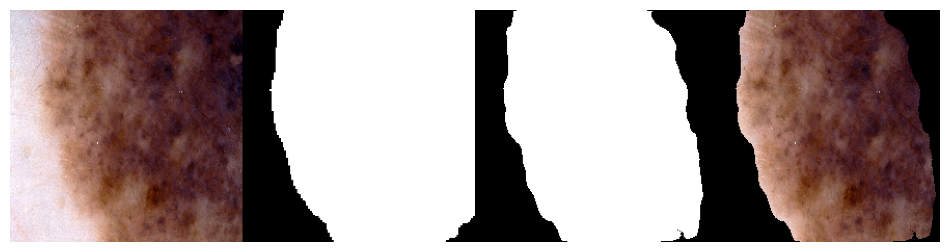

 Epoch: 19 of 100, Iter.: 250 of 250, Train Loss: 0.189561, IoU: 0.836241, Dice: 0.904191
 Epoch: 19 of 100, Iter.: 250 of 250, Valid Loss: 0.410122, IoU: 0.738802, Dice: 0.829110


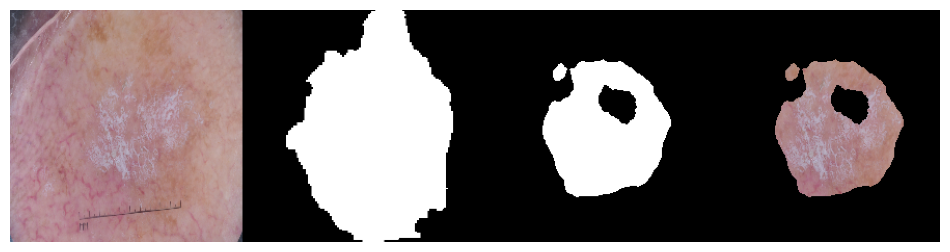

 Epoch: 20 of 100, Iter.: 250 of 250, Train Loss: 0.181449, IoU: 0.840358, Dice: 0.907034
 Epoch: 20 of 100, Iter.: 250 of 250, Valid Loss: 0.439811, IoU: 0.738361, Dice: 0.828892


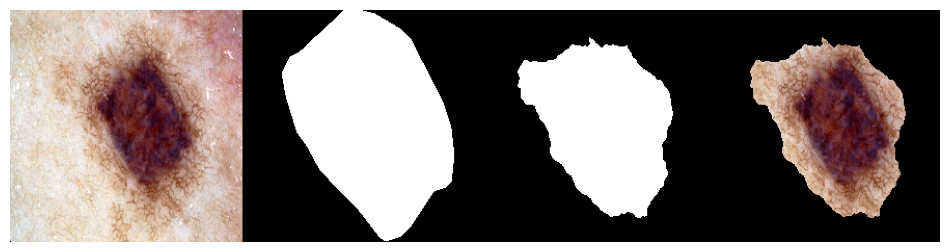

 Epoch: 21 of 100, Iter.: 250 of 250, Train Loss: 0.183941, IoU: 0.838588, Dice: 0.905553
 Epoch: 21 of 100, Iter.: 250 of 250, Valid Loss: 0.429783, IoU: 0.739168, Dice: 0.829120


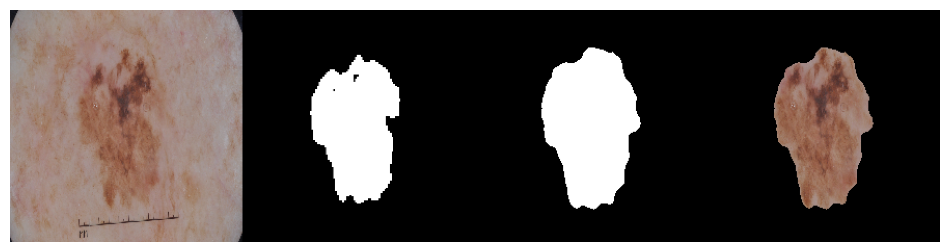

 Epoch: 22 of 100, Iter.: 250 of 250, Train Loss: 0.172291, IoU: 0.845081, Dice: 0.910188
 Epoch: 22 of 100, Iter.: 250 of 250, Valid Loss: 0.441340, IoU: 0.733631, Dice: 0.825580


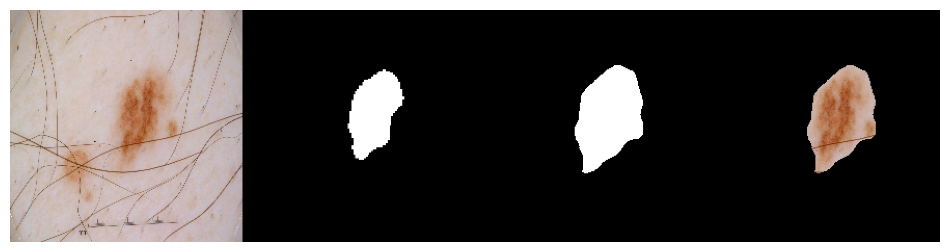

 Epoch: 23 of 100, Iter.: 250 of 250, Train Loss: 0.166595, IoU: 0.847337, Dice: 0.911763
 Epoch: 23 of 100, Iter.: 250 of 250, Valid Loss: 0.416330, IoU: 0.747498, Dice: 0.836971


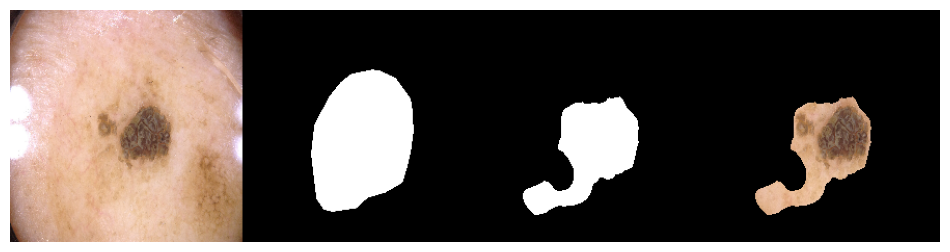

 Epoch: 24 of 100, Iter.: 250 of 250, Train Loss: 0.166188, IoU: 0.848451, Dice: 0.912945
 Epoch: 24 of 100, Iter.: 250 of 250, Valid Loss: 0.466614, IoU: 0.736888, Dice: 0.824427


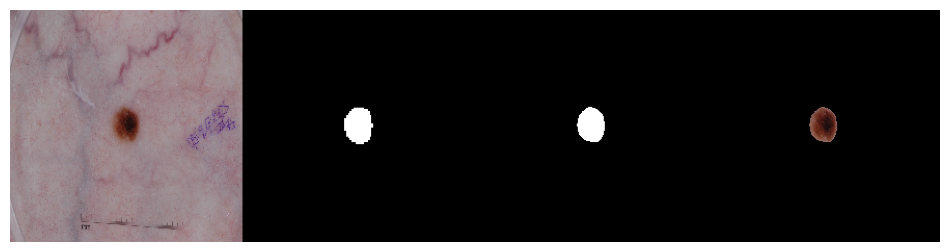

 Epoch: 25 of 100, Iter.: 250 of 250, Train Loss: 0.160030, IoU: 0.850340, Dice: 0.913891
 Epoch: 25 of 100, Iter.: 250 of 250, Valid Loss: 0.445903, IoU: 0.741629, Dice: 0.826785


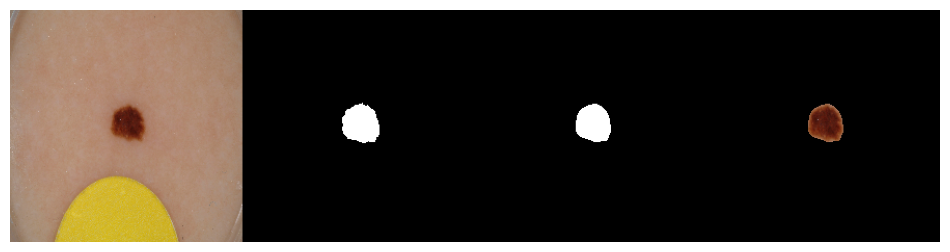

 Epoch: 26 of 100, Iter.: 250 of 250, Train Loss: 0.165847, IoU: 0.848725, Dice: 0.912766
 Epoch: 26 of 100, Iter.: 250 of 250, Valid Loss: 0.445036, IoU: 0.727672, Dice: 0.819472


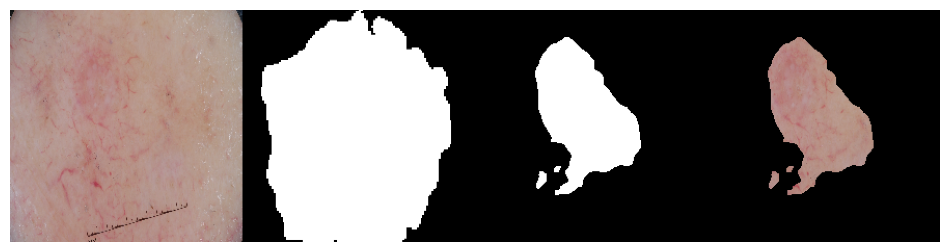

 Epoch: 27 of 100, Iter.: 250 of 250, Train Loss: 0.152209, IoU: 0.855409, Dice: 0.917280
 Epoch: 27 of 100, Iter.: 250 of 250, Valid Loss: 0.507531, IoU: 0.718977, Dice: 0.809024


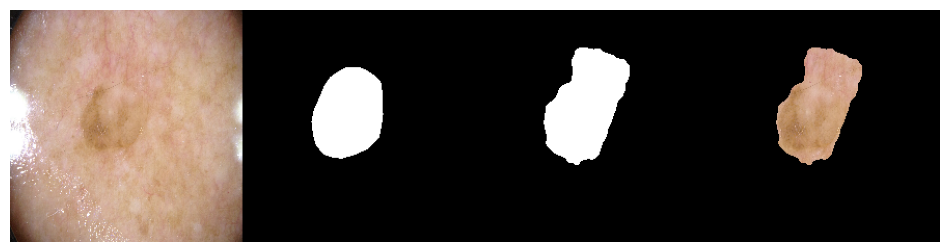

 Epoch: 28 of 100, Iter.: 250 of 250, Train Loss: 0.188939, IoU: 0.833821, Dice: 0.901698
 Epoch: 28 of 100, Iter.: 250 of 250, Valid Loss: 0.406884, IoU: 0.755248, Dice: 0.841379


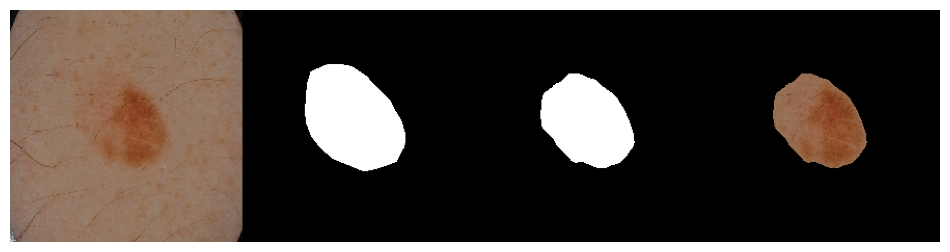

 Epoch: 29 of 100, Iter.: 250 of 250, Train Loss: 0.141854, IoU: 0.862375, Dice: 0.922701
 Epoch: 29 of 100, Iter.: 250 of 250, Valid Loss: 0.462362, IoU: 0.740477, Dice: 0.827991


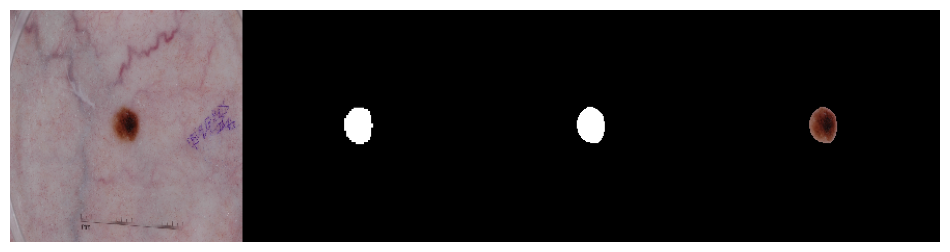

 Epoch: 30 of 100, Iter.: 250 of 250, Train Loss: 0.138703, IoU: 0.863289, Dice: 0.922753
 Epoch: 30 of 100, Iter.: 250 of 250, Valid Loss: 0.479492, IoU: 0.732142, Dice: 0.823777


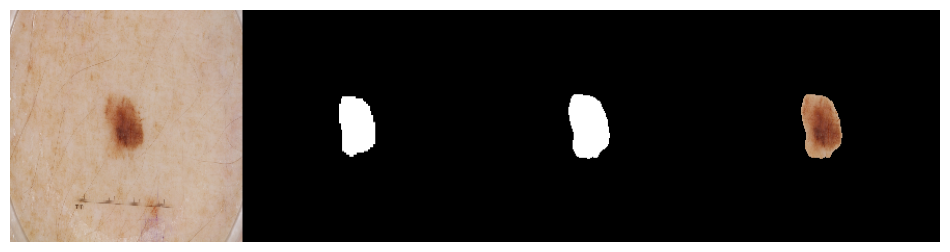

 Epoch: 31 of 100, Iter.: 250 of 250, Train Loss: 0.133650, IoU: 0.866714, Dice: 0.924907
 Epoch: 31 of 100, Iter.: 250 of 250, Valid Loss: 0.463187, IoU: 0.742222, Dice: 0.829258


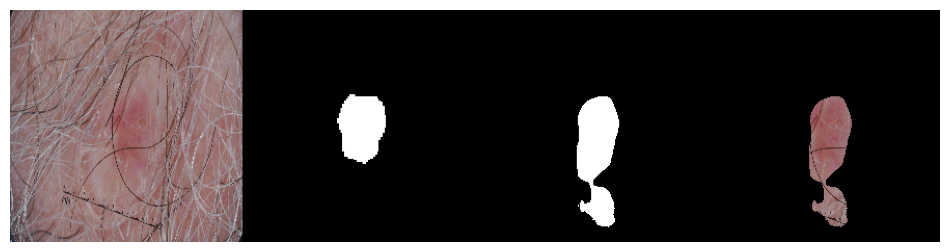

 Epoch: 32 of 100, Iter.: 250 of 250, Train Loss: 0.126532, IoU: 0.871613, Dice: 0.928724
 Epoch: 32 of 100, Iter.: 250 of 250, Valid Loss: 0.452678, IoU: 0.747099, Dice: 0.834564


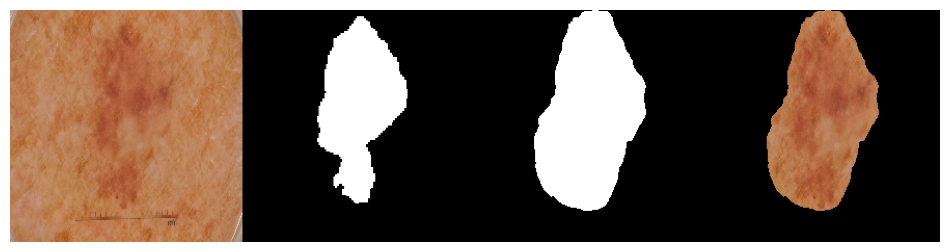

 Epoch: 33 of 100, Iter.: 250 of 250, Train Loss: 0.118295, IoU: 0.876169, Dice: 0.931565
 Epoch: 33 of 100, Iter.: 250 of 250, Valid Loss: 0.418645, IoU: 0.742996, Dice: 0.833319


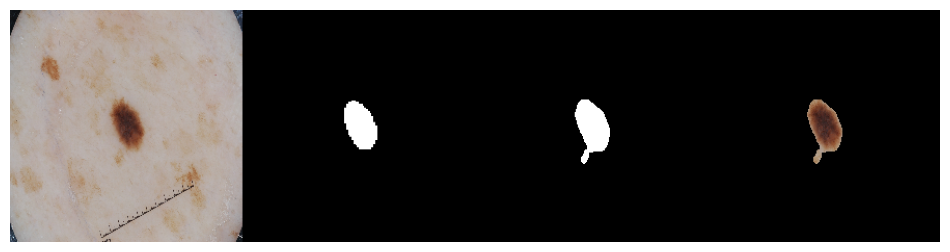

 Epoch: 34 of 100, Iter.: 250 of 250, Train Loss: 0.116997, IoU: 0.878106, Dice: 0.932856
 Epoch: 34 of 100, Iter.: 250 of 250, Valid Loss: 0.488087, IoU: 0.744053, Dice: 0.833884


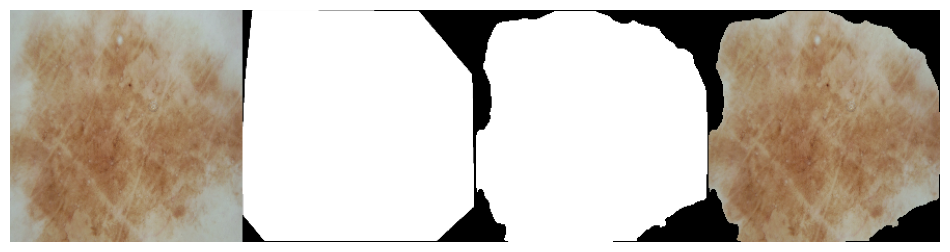

 Epoch: 35 of 100, Iter.: 250 of 250, Train Loss: 0.115165, IoU: 0.878028, Dice: 0.932338
 Epoch: 35 of 100, Iter.: 250 of 250, Valid Loss: 0.491964, IoU: 0.740512, Dice: 0.831598


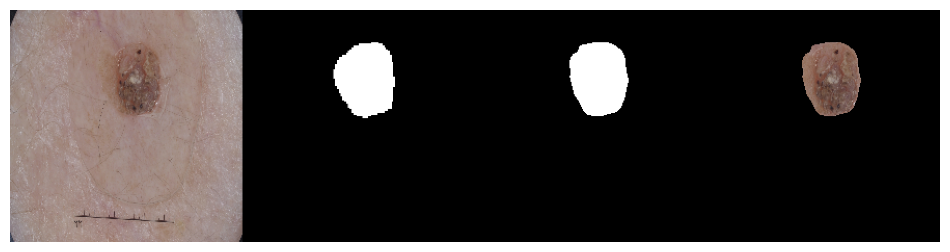

 Epoch: 36 of 100, Iter.: 250 of 250, Train Loss: 0.122380, IoU: 0.873251, Dice: 0.928903
 Epoch: 36 of 100, Iter.: 250 of 250, Valid Loss: 0.462129, IoU: 0.733743, Dice: 0.824473


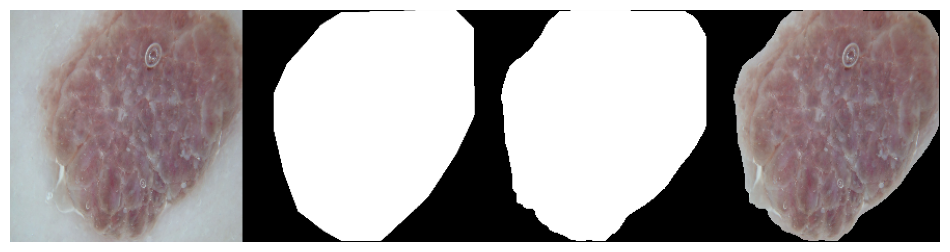

 Epoch: 37 of 100, Iter.: 250 of 250, Train Loss: 0.115035, IoU: 0.878731, Dice: 0.932774
 Epoch: 37 of 100, Iter.: 250 of 250, Valid Loss: 0.447658, IoU: 0.752461, Dice: 0.838605


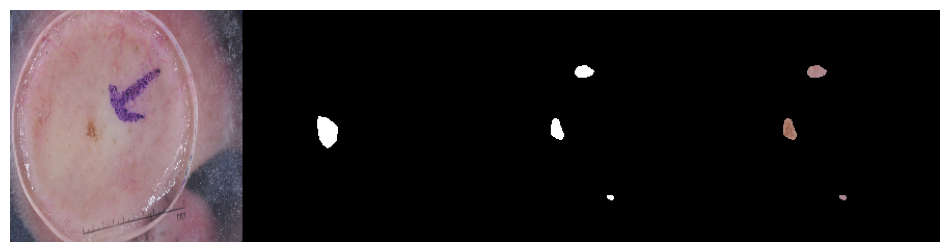

 Epoch: 38 of 100, Iter.: 250 of 250, Train Loss: 0.104979, IoU: 0.886857, Dice: 0.938234
 Epoch: 38 of 100, Iter.: 250 of 250, Valid Loss: 0.504514, IoU: 0.737357, Dice: 0.829004


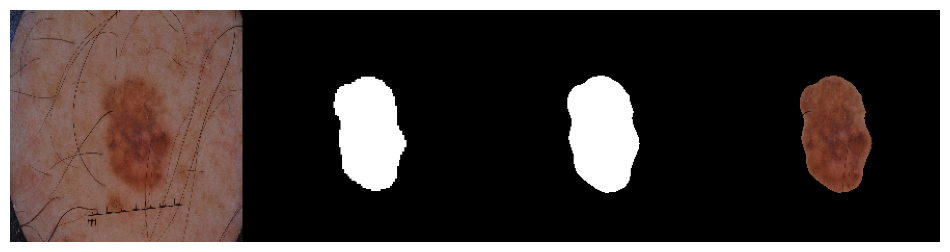

 Epoch: 39 of 100, Iter.: 250 of 250, Train Loss: 0.108491, IoU: 0.883731, Dice: 0.935865
 Epoch: 39 of 100, Iter.: 250 of 250, Valid Loss: 0.478807, IoU: 0.740276, Dice: 0.826574


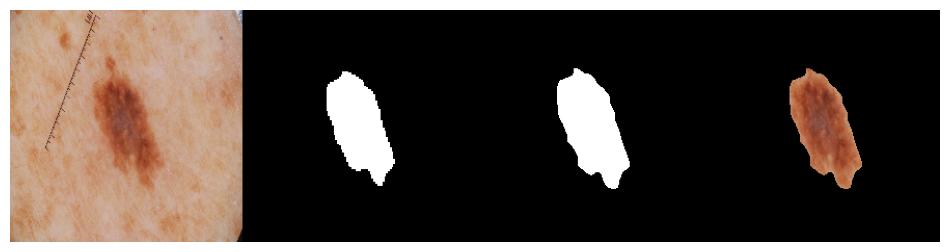

 Epoch: 40 of 100, Iter.: 250 of 250, Train Loss: 0.104073, IoU: 0.886790, Dice: 0.937853
 Epoch: 40 of 100, Iter.: 250 of 250, Valid Loss: 0.513137, IoU: 0.728091, Dice: 0.814946


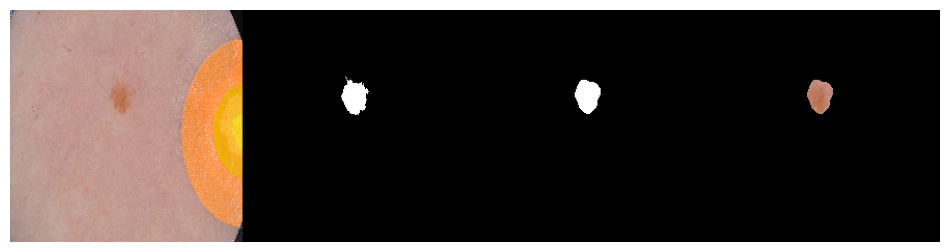

 Epoch: 41 of 100, Iter.: 250 of 250, Train Loss: 0.133625, IoU: 0.866756, Dice: 0.924378
 Epoch: 41 of 100, Iter.: 250 of 250, Valid Loss: 0.421478, IoU: 0.741955, Dice: 0.831693


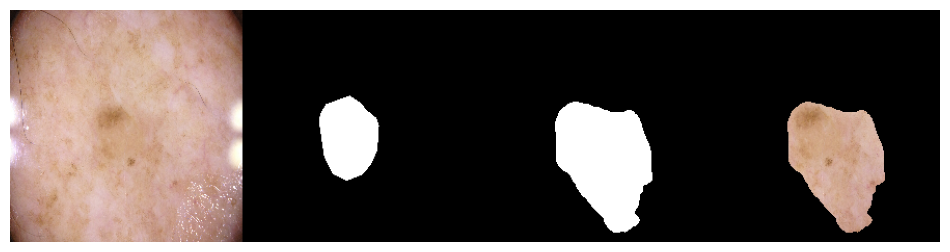

 Epoch: 42 of 100, Iter.: 250 of 250, Train Loss: 0.103242, IoU: 0.886510, Dice: 0.937732
 Epoch: 42 of 100, Iter.: 250 of 250, Valid Loss: 0.517630, IoU: 0.735986, Dice: 0.821952


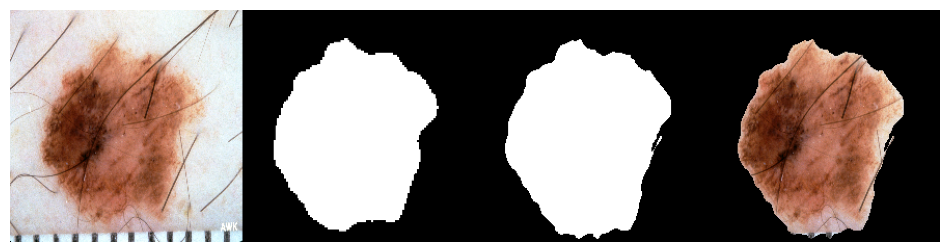

 Epoch: 43 of 100, Iter.: 250 of 250, Train Loss: 0.098089, IoU: 0.891135, Dice: 0.940505
 Epoch: 43 of 100, Iter.: 250 of 250, Valid Loss: 0.506532, IoU: 0.736283, Dice: 0.824325


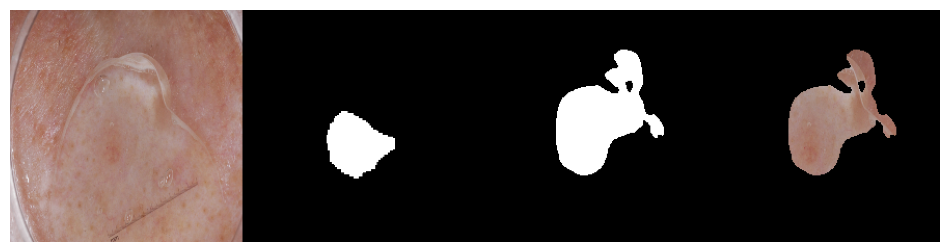

 Epoch: 44 of 100, Iter.: 250 of 250, Train Loss: 0.087566, IoU: 0.901173, Dice: 0.946817
 Epoch: 44 of 100, Iter.: 250 of 250, Valid Loss: 0.548776, IoU: 0.733172, Dice: 0.823359


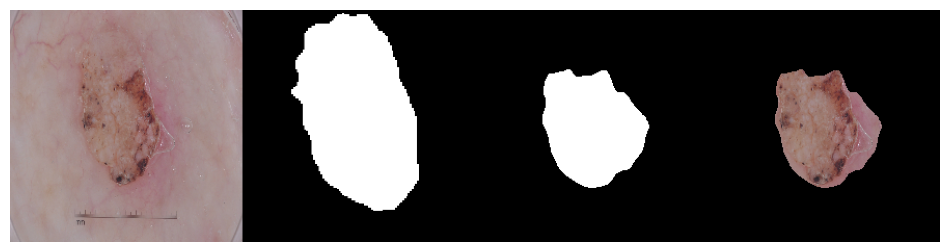

 Epoch: 45 of 100, Iter.: 250 of 250, Train Loss: 0.087838, IoU: 0.900223, Dice: 0.945999
 Epoch: 45 of 100, Iter.: 250 of 250, Valid Loss: 0.529573, IoU: 0.719331, Dice: 0.811702


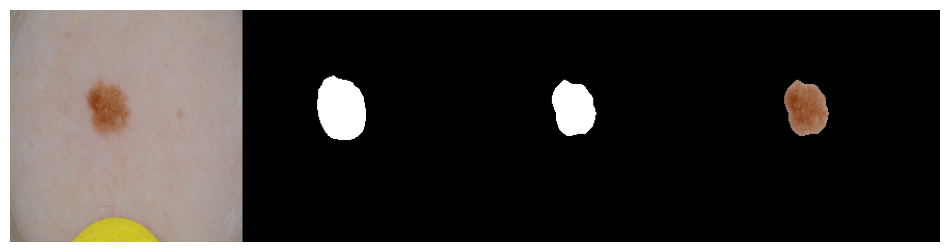

 Epoch: 46 of 100, Iter.: 250 of 250, Train Loss: 0.101136, IoU: 0.889990, Dice: 0.939460
 Epoch: 46 of 100, Iter.: 250 of 250, Valid Loss: 0.524306, IoU: 0.733760, Dice: 0.822416
 Epoch: 47 of 100, Iter.: 250 of 250, Train Loss: 0.080157, IoU: 0.905711, Dice: 0.949345
 Epoch: 47 of 100, Iter.: 250 of 250, Valid Loss: 0.544962, IoU: 0.735618, Dice: 0.823688


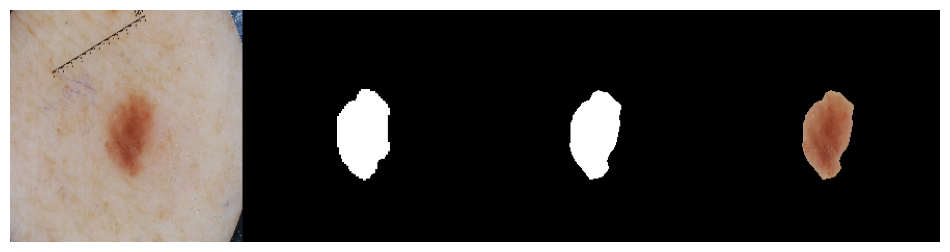

 Epoch: 48 of 100, Iter.: 250 of 250, Train Loss: 0.082309, IoU: 0.904754, Dice: 0.948421
 Epoch: 48 of 100, Iter.: 250 of 250, Valid Loss: 0.546619, IoU: 0.739999, Dice: 0.828664


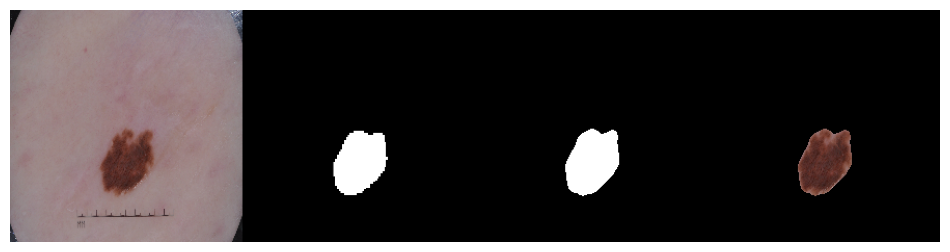

 Epoch: 49 of 100, Iter.: 250 of 250, Train Loss: 0.074132, IoU: 0.911208, Dice: 0.952567
 Epoch: 49 of 100, Iter.: 250 of 250, Valid Loss: 0.586572, IoU: 0.721490, Dice: 0.812005


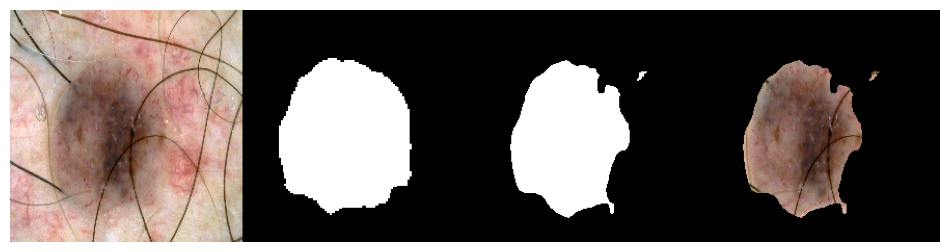


Early stopping. Target criteria has not improved for 20 epochs.

CPU times: user 21min 1s, sys: 18min 37s, total: 39min 38s
Wall time: 4h 11min 39s


In [11]:

%%time
from ploting import plot_model_prediction

train_losses, val_losses = [], []
train_ious, val_ious = [], []
train_dices, val_dices = [], []
best_iou, best_dice, best_loss = 0, 0, np.inf
best_epoch_dice = -1
state = {}
lst_epoch_metric = []

start_time = time.time()
for epoch in range(1, epochs+1):
    running_loss, running_iou, running_dice = 0, 0, 0

    # Train
    model.train()
    for i, (imgs, masks) in enumerate(dataloader_train):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        
        optimizer.zero_grad()
        loss = criterion(prediction, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_iou += iou_pytorch_eval(prediction, masks)
        running_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, IoU:  {:.6f},  Dice:  {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_loss/(i+1), running_iou/(i+1), running_dice/(i+1)), end="")
        
    # Validate
    model.eval()
    val_loss, val_iou, val_dice = 0, 0, 0
    for i, (imgs, masks) in enumerate(dataloader_val):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        loss = criterion(prediction, masks)
        val_loss += loss.item()
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, Val. Loss: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_loss/len(dataloader_train), val_loss/(i+1)), end="")
        
        val_iou += iou_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, IoU: {:.6f}, Val. IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_iou/len(dataloader_train), val_iou/(i+1)), end="")

        val_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Dice: {:.6f}, Val. Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_dice/len(dataloader_train), val_dice/(i+1)), end="")
    
    
    # compute overall epoch losses
    epoch_train_loss = running_loss/len(dataloader_train)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = val_loss/len(dataloader_val)
    val_losses.append(epoch_val_loss)

    # compute overall epoch iou-s
    epoch_train_iou = (running_iou/len(dataloader_train)).item()
    train_ious.append(epoch_train_iou)
    epoch_val_iou = (val_iou/len(dataloader_val)).item()
    val_ious.append(epoch_val_iou)
    
    # compute overall epoch dice
    epoch_train_dice = (running_dice/len(dataloader_train)).item()
    train_dices.append(epoch_train_dice)
    epoch_val_dice = (val_dice/len(dataloader_val)).item()
    val_dices.append(epoch_val_dice)

    print("\r Epoch: {} of {}, Iter.: {} of {}, Train Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_train_loss, epoch_train_iou, epoch_train_dice))
    print("\r Epoch: {} of {}, Iter.: {} of {}, Valid Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_val_loss, epoch_val_iou, epoch_val_dice))
    if epoch == 1:
        print('\n시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.')
    plot_model_prediction(model, DEVICE, valid_images, valid_labels)
        
    # plot
    metrics = {'loss':[train_losses, epoch_train_loss, val_losses, epoch_val_loss],
               'Iou':[train_ious, epoch_train_iou, val_ious,  epoch_val_iou],
               'Dice':[train_dices, epoch_train_dice, val_dices,  epoch_val_dice]}
    
    lst_epoch_metric.append([round(epoch_train_loss,4), round(epoch_train_iou,4), round(epoch_train_dice,4), 
                             round(epoch_val_loss,4), round(epoch_val_iou,4), round(epoch_val_dice,4)]) 

    # save if best results or break is has not improved for {patience} number of epochs
    best_iou = max(best_iou, epoch_val_iou)
    best_dice = max(best_dice, epoch_val_dice)
    best_loss = min(best_loss, epoch_val_loss)
    best_epoch_dice = epoch if best_dice == epoch_val_dice else best_epoch_dice

    # record losses
    state['train_losses'] = train_losses
    state['val_losses'] = val_losses
    
    if best_epoch_dice == epoch:
        # print('Saving..')
        state['net'] = model.state_dict()
        state['dice'] = best_dice
        state['epoch'] = epoch
            
        if not os.path.isdir('checkpoints'):
            os.mkdir('checkpoints')
        torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
    
    
    elif best_epoch_dice + patience < epoch:
        print(f"\nEarly stopping. Target criteria has not improved for {patience} epochs.\n")
        break

file_name = f'{model_name}_{data_name}'
# load once more and write all the losses down (othw can miss the last 10)
end_time = time.time() - start_time

state = torch.load(f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
state['train_losses'] = train_losses
state['val_losses'] = val_losses
torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')

df_epoch_metric = pd.DataFrame(lst_epoch_metric, columns = ['epoch_train_loss', 'epoch_val_loss', 'epoch_train_iou', 'epoch_val_iou', 'epoch_train_dice', 'epoch_val_dice'])
df_epoch_metric.to_csv(f'/project/segmentation/smcho1201/training_{model_name}/csv_{file_name}.csv', index_label = ['epoch'])

Validationset 기준 
Best_epoch:28, Best_IOU:0.7552, Best_DiceScore:0.8414


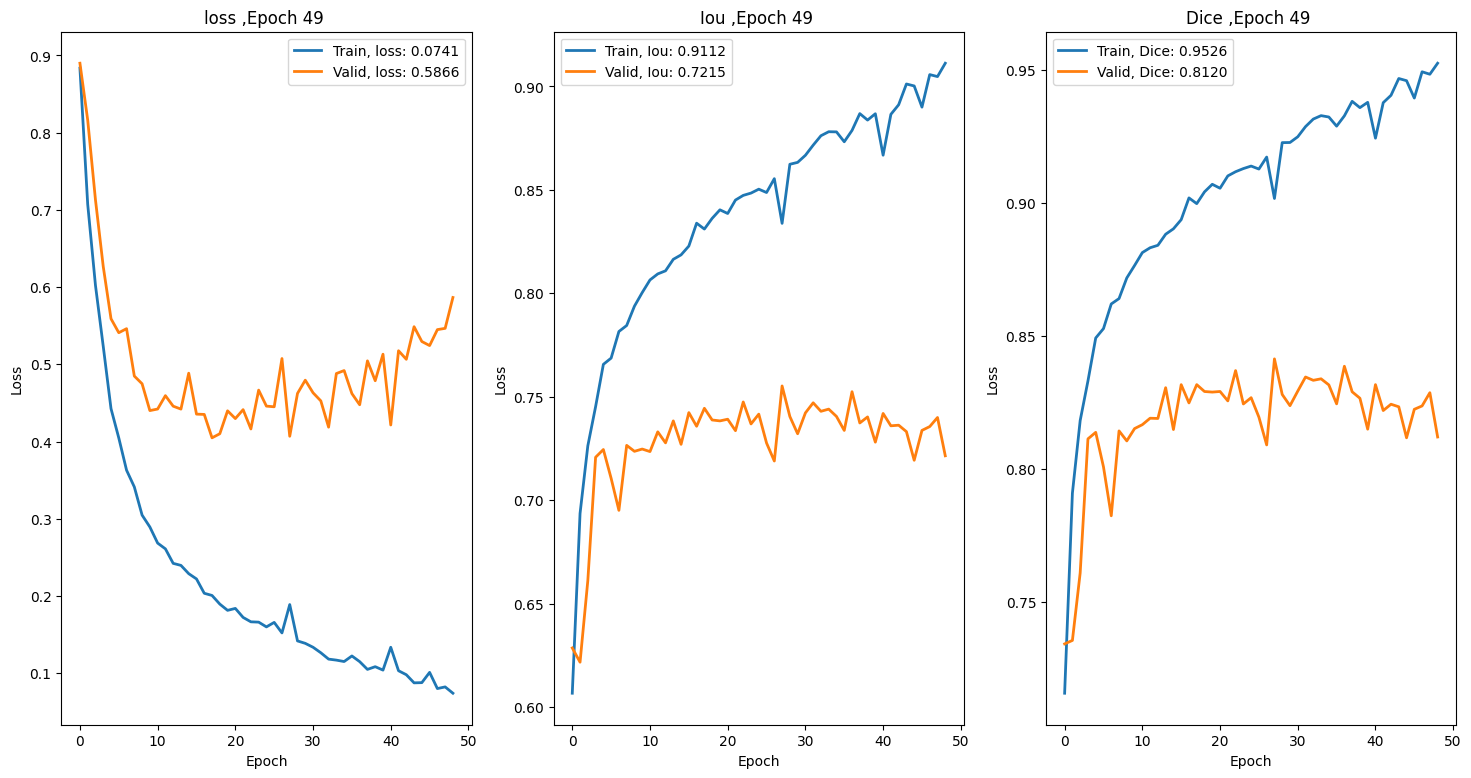

In [12]:
print(f'Validationset 기준 \nBest_epoch:{best_epoch_dice}, Best_IOU:{best_iou:.4f}, Best_DiceScore:{best_dice:.4f}')

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))           
for i, (metric, value) in enumerate(metrics.items()):
    axs[i].plot(np.arange(len(value[0])), value[0], label=f'Train, {metric}: {value[1]:.4f}', linewidth=2)
    axs[i].plot(np.arange(len(value[2])), value[2], label=f'Valid, {metric}: {value[3]:.4f}', linewidth=2)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Loss')
    axs[i].set_title(f'{metric} ,Epoch {epoch} ')
    axs[i].legend(loc='best')
plt.show()